# **Aprendizado de máquina para auxiliar o planejamento de oferta de disciplinas na Universidade Federal do ABC**

Baixando as bibliotecas necessárias

In [ ]:
!pip install pandas
!pip install networkx
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install sklearn

Importando bibliotecas

In [29]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Criando um dataframe com os dados


In [30]:
df_original= pd.read_excel('dados/database_alunos.xlsx')
df_original.shape

(29635, 7)

Tirando as colunas que não serão utilizadas



In [31]:
df_todos_alunos_todas_materias = df_original.copy()
df_todos_alunos_todas_materias.drop(columns=['COD_ATIV_CURRIC','CONCEITO'], axis = 1, inplace=True)

Modificando a escrita da coluna Periodo

In [32]:
df_todos_alunos_todas_materias['PERIODO'] = df_todos_alunos_todas_materias['PERIODO'].str[:1].apply(pd.to_numeric)

Filtrando para ter apenas os dados de quando foi feita uma matéria definida como obrigatória

In [33]:
materias_obrigatorias = [
'Fundamentos de Fotônica',
'Circuitos Elétricos I',
'Fundamentos de Eletromagnetismo Aplicado',
'Circuitos Elétricos II',
'Dispositivos Eletrônicos',
'Eletrônica Analógica Aplicada',
'Eletrônica Digital',
'Transformadas em Sinais e Sistemas Lineares',
'Princípios de Comunicação',
'Sistemas de Controle I',
'Redes de Computadores',
'Sinais Aleatórios',
'Processamento Digital de Sinais',
'Comunicação Digital',
'Teoria da Informação e Códigos',
'Ondas Eletromagnéticas Aplicadas',
'Comunicações Ópticas',
'Codificação de Sinais Multimídia',
'Sistemas Microprocessados',
'Comunicações Móveis',
'Teoria de Filas e Análise de Desempenho',
]

df_alunos_materias_info = df_todos_alunos_todas_materias.loc[df_todos_alunos_todas_materias['NOME_ATIV_CURRIC'].isin(materias_obrigatorias)]

Filtrando apenas o RA dos alunos matrículados na Engenharia de Informação

In [34]:
df_somente_curso_especifico = pd.read_excel('dados/somente_curso_especifico.xlsx')

df_merge = pd.merge(df_alunos_materias_info, df_somente_curso_especifico, left_on='RA_ANONIMIZADO', right_on='RA_ANONIMIZADO', how='left')

df_merge

df_merge = df_merge.loc[(df_merge['NOME_CURSO_DIPLOMA'] == "Engenharia de Informação")]

lista_alunos_informacao = df_merge['RA_ANONIMIZADO'].unique()

Filtrando os alunos que estão matrículados na Engenharia de Informação ou que realizaram pelo menos 11 disciplinas do curso

In [35]:
df_alunos_matriculados_ou_mtas_materias = df_alunos_materias_info.groupby('RA_ANONIMIZADO')\
            .filter(lambda x: x['NOME_ATIV_CURRIC'].nunique() == 11 or x['RA_ANONIMIZADO'].iloc[0] in lista_alunos_informacao)

Filtrando os alunos ativos (aqueles que realizaram ao menos 1 disciplina nos últimos 3 quadrimestres)

In [36]:
# Descobrindo o ano máximo e período máximo do dataframe
ano_maximo = df_alunos_matriculados_ou_mtas_materias['ANO'].max()
quadrimestre_maximo = df_alunos_matriculados_ou_mtas_materias[df_alunos_matriculados_ou_mtas_materias['ANO'] == ano_maximo]['PERIODO'].max()

# Descobrindo os 3 últimos quadrimestres que devem ser levados em consideração
anos_quadrimestre = [(ano_maximo, quadrimestre_maximo)]
for i in range(1, 3):
    ano = ano_maximo - (i // 3)
    quadrimestre = quadrimestre_maximo - (i % 3)
    if quadrimestre == 0:
        ano -= 1
        quadrimestre += 3
    anos_quadrimestre.append((ano, quadrimestre))

# Considerando apenas os 3 últimos quadrimestres
df_alunos_ativos = pd.DataFrame()
for ano, quadrimestre in anos_quadrimestre:
    df_alunos_ativos = pd.concat([df_alunos_ativos, df_alunos_matriculados_ou_mtas_materias[(df_alunos_matriculados_ou_mtas_materias['ANO'] == ano) & \
                          (df_alunos_matriculados_ou_mtas_materias['PERIODO'] == quadrimestre)]])

# Criando uma lista apenas com o RA dos alunos ativos
lista_alunos_ativos = df_alunos_ativos['RA_ANONIMIZADO'].unique()

# Filtrando só pelos alunos que estão ativos
df_apenas_alunos_ativos = df_alunos_matriculados_ou_mtas_materias[df_alunos_matriculados_ou_mtas_materias['RA_ANONIMIZADO']\
                                                                  .isin(lista_alunos_ativos)]

Criação dos grafos para saber as próximas disciplinas a partir das disciplinas já realizadas

In [37]:
def proximas_materias(materias_feitas):
    materias = nx.DiGraph()

    materias.add_node('Aluno', candidato = 'nao', visitado='sim', quad=7)
    materias.add_node('Fundamentos de Fotônica', candidato = 'nao', visitado='nao', quad=7)
    materias.add_node('Transformadas em Sinais e Sistemas Lineares', candidato = 'nao', visitado='nao', quad=8)
    materias.add_node('Sinais Aleatórios', candidato = 'nao', visitado='nao', quad=8)
    materias.add_node('Circuitos Elétricos I', candidato = 'nao', visitado='nao', quad=8)
    materias.add_node('Princípios de Comunicação', candidato = 'nao', visitado='nao', quad=9)
    materias.add_node('Redes de Computadores', candidato = 'nao', visitado='nao', quad=9)
    materias.add_node('Dispositivos Eletrônicos', candidato = 'nao', visitado='nao', quad=9)
    materias.add_node('Circuitos Elétricos II', candidato = 'nao', visitado='nao', quad=9)
    materias.add_node('Processamento Digital de Sinais', candidato = 'nao', visitado='nao', quad=9)
    materias.add_node('Sistemas de Controle I', candidato = 'nao', visitado='nao', quad=10)
    materias.add_node('Eletrônica Analógica Aplicada', candidato = 'nao', visitado='nao', quad=10)
    materias.add_node('Eletrônica Digital', candidato = 'nao', visitado='nao', quad=10)
    materias.add_node('Codificação de Sinais Multimídia', candidato = 'nao', visitado='nao', quad=11)
    materias.add_node('Comunicação Digital', candidato = 'nao', visitado='nao', quad=11)
    materias.add_node('Fundamentos de Eletromagnetismo Aplicado', candidato = 'nao', visitado='nao', quad=11)
    materias.add_node('Sistemas Microprocessados', candidato = 'nao', visitado='nao', quad=11)
    materias.add_node('Comunicações Ópticas', candidato = 'nao', visitado='nao', quad=12)
    materias.add_node('Teoria da Informação e Códigos', candidato = 'nao', visitado='nao', quad=12)
    materias.add_node('Ondas Eletromagnéticas Aplicadas', candidato = 'nao', visitado='nao', quad=12)
    materias.add_node('Teoria de Filas e Análise de Desempenho', candidato = 'nao', visitado='nao', quad=13)
    materias.add_node('Comunicações Móveis', candidato = 'nao', visitado='nao', quad=13)


    arestas = [('Fundamentos de Fotônica','Comunicações Ópticas'),
    ('Circuitos Elétricos I','Circuitos Elétricos II'),
    ('Circuitos Elétricos I','Eletrônica Digital'),
    ('Circuitos Elétricos I','Dispositivos Eletrônicos'),
    ('Circuitos Elétricos I','Fundamentos de Eletromagnetismo Aplicado'),
    ('Dispositivos Eletrônicos','Eletrônica Analógica Aplicada'),
    ('Dispositivos Eletrônicos','Sistemas Microprocessados'),
    ('Eletrônica Digital','Sistemas Microprocessados'),
    ('Fundamentos de Eletromagnetismo Aplicado','Ondas Eletromagnéticas Aplicadas'),
    ('Ondas Eletromagnéticas Aplicadas','Comunicações Móveis'),
    ('Comunicação Digital','Comunicações Móveis'),
    ('Comunicação Digital','Teoria da Informação e Códigos'),
    ('Princípios de Comunicação','Comunicação Digital'),
    ('Sinais Aleatórios','Comunicação Digital'),
    ('Sinais Aleatórios','Teoria de Filas e Análise de Desempenho'),
    ('Transformadas em Sinais e Sistemas Lineares','Princípios de Comunicação'),
    ('Transformadas em Sinais e Sistemas Lineares','Sinais Aleatórios'),
    ('Transformadas em Sinais e Sistemas Lineares','Sistemas de Controle I'),
    ('Transformadas em Sinais e Sistemas Lineares','Processamento Digital de Sinais'),
    ('Processamento Digital de Sinais','Codificação de Sinais Multimídia'),
    ('Redes de Computadores','Teoria de Filas e Análise de Desempenho'),
    ('Aluno','Redes de Computadores'),
    ('Aluno','Transformadas em Sinais e Sistemas Lineares'),
    ('Aluno','Circuitos Elétricos I'),
    ('Aluno','Fundamentos de Fotônica')
    ]

    materias.add_edges_from(arestas)

    # A partir de um array com as matérias que o aluno fez é colocada a propriedade 'visitada' como sim
    for materia in materias_feitas:
        materias.nodes()[materia]['visitado'] = 'sim'

    todas_materias_caminho_feitas = 'sim'

    # É analisado todos os caminhos da raiz até chegar em uma matéria, se durante o caminho até chegar nela todas as matérias
    # tiverem feitas, eu defino aquela matéria como sendo candidata
    for materia in materias:
        if(materias.nodes()[materia]['visitado'] == 'nao'):
            for caminho_de_materias in nx.all_simple_paths(materias, source='Aluno', target=[materia]):
                caminho_de_materias.pop(0)
                caminho_de_materias.pop()
                for materias_caminho in caminho_de_materias:
                    if(materias.nodes()[materias_caminho]['visitado'] == 'nao'):
                        todas_materias_caminho_feitas = 'nao'
            if (todas_materias_caminho_feitas == 'sim'):
                materias.nodes()[materia]['candidato'] = 'sim'
            else:
                materias.nodes()[materia]['candidato'] = 'nao'

            todas_materias_caminho_feitas = 'sim'

    materias_falta_fazer = []

    for materia in materias:
        if(materias.nodes()[materia]['candidato'] == 'sim'):
            materias_falta_fazer.append(materia)


    return materias_falta_fazer

Criando uma tabela para cada matéria que os alunos fizeram

In [38]:
# Agrupando cada aluno em um array em que a Key é o RA do aluno e os values são as matérias que ele já fez

alunos_materias_feitas = df_apenas_alunos_ativos.groupby('RA_ANONIMIZADO')['NOME_ATIV_CURRIC'].apply(list).to_dict()

data = {
    'materia': materias_obrigatorias,
    'qtd_necessaria': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
}

df_materias_faltam = pd.DataFrame(data)
# Iterando sobre as matérias feitas dos alunos (dicionário) e colocando no grafo para ver a próxima matéria de cada aluno
for materias_feitas in alunos_materias_feitas.values():
     aux = proximas_materias(materias_feitas)
     for materia in aux:
      df_materias_faltam.loc[df_materias_faltam['materia'] == materia, 'qtd_necessaria'] += 1

df_materias_faltam

,materia,qtd_necessaria
0,Fundamentos de Fotônica,41
1,Circuitos Elétricos I,5
2,Fundamentos de Eletromagnetismo Aplicado,21
3,Circuitos Elétricos II,8
4,Dispositivos Eletrônicos,4
5,Eletrônica Analógica Aplicada,6
6,Eletrônica Digital,7
7,Transformadas em Sinais e Sistemas Lineares,8
8,Princípios de Comunicação,14
9,Sistemas de Controle I,6


<Axes: xlabel='Matérias que os já realizaram', ylabel='Matérias Info'>

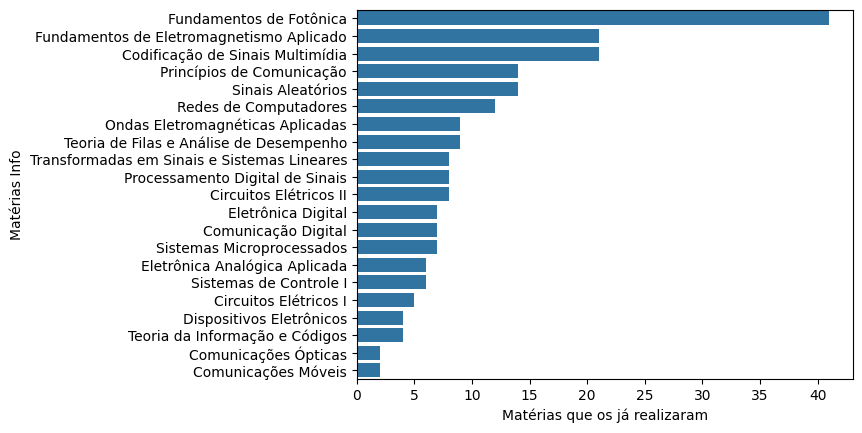

In [39]:
grafico = sns.barplot(y="materia", x="qtd_necessaria", data = df_materias_faltam, order=df_materias_faltam.sort_values('qtd_necessaria',ascending = False).materia)
grafico.set(xlabel='Matérias que os já realizaram', ylabel='Matérias Info')
grafico

***TREINAMENTO DO MODELO***

Definindo a porcentagem de aprovação de todas as disciplina em cada quadrimestre de cada ano

In [40]:
df_porcent_reprov = df_alunos_materias_info.copy()

ano_limite = df_porcent_reprov['ANO'].max()
periodo_limite = df_porcent_reprov[df_porcent_reprov['ANO'] == ano_maximo]['PERIODO'].max()

aprovacao_por_ano_periodo = []

for ano in range(df_porcent_reprov['ANO'].min(), ano_limite + 1):
    for periodo in range(1, 4):
        if (ano < ano_limite) or (ano == ano_limite and periodo <= periodo_limite):
            # Filtrando o DataFrame com base no ano e período especificados
            df_temp = df_porcent_reprov.loc[(df_porcent_reprov['ANO'] < ano) | ((df_porcent_reprov['ANO'] == ano) & (df_porcent_reprov['PERIODO'] <= periodo))]

            porcent_aprov_materias = df_temp.groupby('NOME_ATIV_CURRIC')['SITUACAO'].value_counts().to_dict()
            aprovacao_por_materia = {}


            aprovacao_por_materia['ano'] = ano
            aprovacao_por_materia['periodo'] = periodo

            for materia in materias_obrigatorias:
              aprovacao_por_materia[materia]= round(float(1),4)

            for key, value in porcent_aprov_materias.items():
                materia = key[0]
                status = key[1]
                if status == 'Aprovado':
                    aprovados = value
                elif status == 'Reprovado':
                    reprovados = value
                    aprovacao_por_materia[materia] = round((aprovados / (aprovados + reprovados)),4)

        aprovacao_por_ano_periodo.append(aprovacao_por_materia)

Criando uma lista de dataframes, onde cada dataframe é um aluno

In [41]:
df_todos_alunos = df_alunos_materias_info.loc[(df_alunos_materias_info['SITUACAO'] == "Aprovado") \
| (df_alunos_materias_info['SITUACAO'] == "Reprovado") | (df_alunos_materias_info['SITUACAO'] == "Reprovado por Frequência")]

df_todos_alunos.loc[df_todos_alunos['SITUACAO'] == 'Reprovado por Frequência', 'SITUACAO'] = 'Reprovado'

df_alunos = []

# Iterar sobre cada aluno único
for aluno_id, dados_aluno in df_todos_alunos.groupby('RA_ANONIMIZADO'):
    df_aluno_atual = pd.DataFrame(dados_aluno)
    df_alunos.append(df_aluno_atual)

Criando um dataframe com a estrutura correta para o treinamento do modelo

In [42]:
# Definindo os códigos das disciplinas
codigos_disciplinas = {
    'Fundamentos de Fotônica': 1,
    'Circuitos Elétricos I': 2,
    'Fundamentos de Eletromagnetismo Aplicado': 3,
    'Circuitos Elétricos II': 4,
    'Dispositivos Eletrônicos': 5,
    'Eletrônica Analógica Aplicada': 6,
    'Eletrônica Digital': 7,
    'Transformadas em Sinais e Sistemas Lineares': 8,
    'Princípios de Comunicação': 9,
    'Sistemas de Controle I': 10,
    'Redes de Computadores': 11,
    'Sinais Aleatórios': 12,
    'Processamento Digital de Sinais': 13,
    'Comunicação Digital': 14,
    'Teoria da Informação e Códigos': 15,
    'Ondas Eletromagnéticas Aplicadas': 16,
    'Comunicações Ópticas': 17,
    'Codificação de Sinais Multimídia': 18,
    'Sistemas Microprocessados': 19,
    'Comunicações Móveis': 20,
    'Teoria de Filas e Análise de Desempenho': 21,
}

df_estrutura_treino_ML = []

colunas = ['RA_ANONIMIZADO']
colunas.extend(materias_obrigatorias)
colunas.extend(['PORCENT_APROV', 'MATERIA', 'PASSOU'])

for df_aluno in df_alunos:

  # aqui é o dataframe completo
  df_temp = pd.DataFrame(columns=colunas)

  for indice, linha in df_aluno.iterrows():
    linha_atual = linha.copy()
    df_temp.loc[indice,'RA_ANONIMIZADO']= linha_atual['RA_ANONIMIZADO']
    df_temp.loc[indice,'MATERIA']= codigos_disciplinas[linha_atual['NOME_ATIV_CURRIC']]
    materia = linha_atual['NOME_ATIV_CURRIC']

    situacao = linha_atual['SITUACAO']
    if(situacao == 'Aprovado'):
      df_temp.loc[indice,'PASSOU'] = int(1)
    elif(situacao == 'Reprovado'):
      df_temp.loc[indice,'PASSOU'] = int(0)

    ano_limite = linha_atual['ANO']
    periodo_limite= linha_atual['PERIODO']

    for dicionario in aprovacao_por_ano_periodo:
      if dicionario['ano'] == ano_limite and dicionario['periodo'] == periodo_limite:
        porcentagem_materia = dicionario[materia]

    df_temp.loc[indice,'PORCENT_APROV'] = round(porcentagem_materia, 4)

    df_pegando_materias = df_aluno.loc[((df_aluno['ANO'] < ano) | ((df_aluno['ANO'] == ano) & (df_aluno['PERIODO'] < periodo))) & (df_aluno['SITUACAO'] == 'Aprovado')]


    if not df_pegando_materias.empty:
      materias_feitas_aluno = df_pegando_materias['NOME_ATIV_CURRIC'].unique().tolist()
      for materia_feita in materias_feitas_aluno:
       df_temp.loc[indice,materia_feita] = int(1)



  df_temp = df_temp.fillna(0)

  df_estrutura_treino_ML.append(df_temp.copy())

Treinamento do modelo

In [43]:
df_ml = pd.concat(df_estrutura_treino_ML, ignore_index=True)
df_ml.drop(columns=['RA_ANONIMIZADO'], axis=1, inplace=True)

X = df_ml.drop('PASSOU', axis=1)
y = df_ml['PASSOU']

# Dividindo os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=32)

clf = DecisionTreeClassifier()

# Treinando o modelo
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)


Acurácia: 0.8023155348194229


***Estrutura do sistema: GRAFO -> MODELO -> GRAFO -> RESULTADO***


Primeiro grafo

In [44]:
df_estrutura_ML = []

materias_realizando = []

colunas = ['RA_ANONIMIZADO']
colunas.extend(materias_obrigatorias)
colunas.extend(['PORCENT_APROV', 'MATERIA'])


ano_desejado = df_apenas_alunos_ativos['ANO'].max()
periodo_desejado = df_apenas_alunos_ativos[df_apenas_alunos_ativos['ANO'] == ano_maximo]['PERIODO'].max()

df_para_estrutura_ml = []

# Iterar sobre cada aluno único
for aluno, dados_aluno in df_apenas_alunos_ativos.groupby('RA_ANONIMIZADO'):
    # Crie um novo dataframe apenas para o aluno atual
    df_aluno_atual = pd.DataFrame(dados_aluno)
    # Adicione o dataframe do aluno à lista de dataframes
    df_para_estrutura_ml.append(df_aluno_atual)

for df_aluno in df_para_estrutura_ml:
  df_pegando_materias = df_aluno.loc[((df_aluno['ANO'] < ano_desejado) | ((df_aluno['ANO'] == ano_desejado)
    & (df_aluno['PERIODO'] < periodo_desejado))) & (df_aluno['SITUACAO'] == 'Aprovado')]

  materias_feitas_aluno = df_pegando_materias['NOME_ATIV_CURRIC'].unique().tolist()

  #array de próximas matérias que um aluno deve fazer
  proximas_materias_aluno_fazer = proximas_materias(materias_feitas_aluno)
  materias_realizando.append(proximas_materias_aluno_fazer)
  df_temp = pd.DataFrame(columns=colunas)
  ra_aluno = df_aluno['RA_ANONIMIZADO'].unique()[0]

  if len(proximas_materias_aluno_fazer) != 0:
    contador = 0
    for indice, materia in enumerate(proximas_materias_aluno_fazer):
      df_temp.loc[indice,'RA_ANONIMIZADO']= ra_aluno
      for materia_feita in materias_feitas_aluno:
        df_temp.loc[indice,materia_feita] = int(1)

      for dicionario in aprovacao_por_ano_periodo:
        if dicionario['ano'] == ano_desejado and dicionario['periodo'] == periodo_desejado:
          df_temp.loc[indice,'PORCENT_APROV'] = round(dicionario[materia], 4)

      df_temp.loc[indice,'MATERIA']= codigos_disciplinas[materia]
    df_temp = df_temp.fillna(0)
    df_estrutura_ML.append(df_temp.copy())

<Axes: xlabel='Matérias que os alunos estão realizando no quadrimestre', ylabel='Matérias Info'>

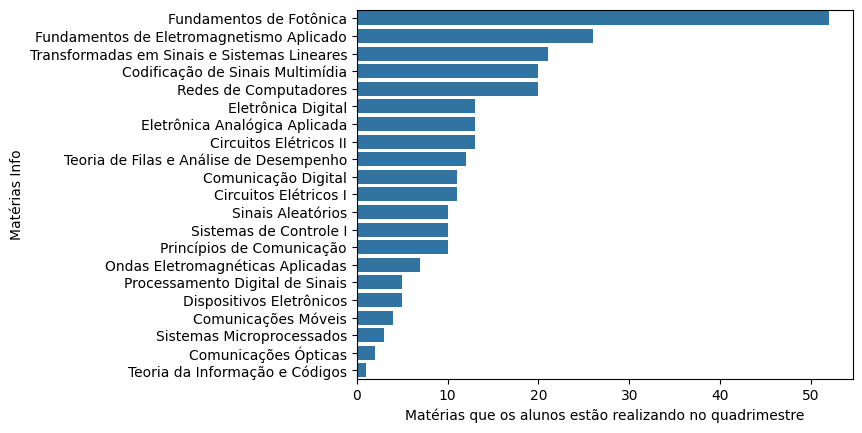

In [45]:
# Transformando o array em uma única lista
flat_list = [item for sublist in materias_realizando for item in sublist]

# Contando a quantidade de vezes que cada string aparece
word_count = {}
for word in flat_list:
    if word in word_count:
        word_count[word] += 1
    else:
        word_count[word] = 1

# Transformando em DataFrame
df_materias_realizadas = pd.DataFrame(list(word_count.items()), columns=['materia', 'qtd_realizando'])


grafico = sns.barplot(y="materia", x="qtd_realizando", data = df_materias_realizadas, order=df_materias_realizadas.sort_values('qtd_realizando',ascending = False).materia)
grafico.set(xlabel='Matérias que os alunos estão realizando no quadrimestre', ylabel='Matérias Info')
grafico

In [46]:
df_estrutura_ML = pd.concat(df_estrutura_ML)
df_estrutura_ML = df_estrutura_ML.reset_index(drop=True)

Modelo para previsão das aprovações

In [47]:
coluna_RA = df_estrutura_ML['RA_ANONIMIZADO'].copy()
df_estrutura_ML = df_estrutura_ML.drop(columns=['RA_ANONIMIZADO'])
predictions = clf.predict(df_estrutura_ML.values)
df_estrutura_ML.insert(0, 'RA_ANONIMIZADO', coluna_RA)
df_estrutura_ML['PASSOU'] = predictions

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Colocando as predições no dataframe


In [48]:
df_grafo2 = df_estrutura_ML.loc[df_estrutura_ML['PASSOU'] == 1].copy()

disciplinas_codigos = {value: key for key, value in codigos_disciplinas.items()}

df_grafo2['MATERIA'] = df_grafo2['MATERIA'].map(disciplinas_codigos)

alunos_materias = {}

for indice, linha in df_grafo2.iterrows():
    ra = linha['RA_ANONIMIZADO']
    materia = linha['MATERIA']

    if ra not in alunos_materias:
        alunos_materias[ra] = []

    alunos_materias[ra].append(materia)

df_grafo2 = df_grafo2.drop_duplicates().drop(columns=['PORCENT_APROV', 'MATERIA', 'PASSOU'])

for aluno, materias_realizadas in alunos_materias.items():
    for materia in materias_realizadas:
        df_grafo2.loc[df_grafo2['RA_ANONIMIZADO'] == aluno, materia] = int(1)

Criando o segundo grafo a partir das matérias previstas de terem sido feitas


In [49]:
dicionario_disciplinas = {}
for index, row in df_grafo2.iterrows():
  disciplinas_feitas = []
  for coluna in df_grafo2.columns[1:]:  
    if row[coluna] == 1:
      disciplinas_feitas.append(coluna)
  dicionario_disciplinas[row['RA_ANONIMIZADO']] = disciplinas_feitas

In [50]:
data = {
    'materia': materias_obrigatorias,
    'qtd_necessaria': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
}

df_materias_faltam2 = pd.DataFrame(data)
#iterando sobre as matérias feitas dos alunos (dicionário) e colocando no grafo para ver a próxima matéria de cada aluno
for materias_feitas in dicionario_disciplinas.values():
     aux = proximas_materias(materias_feitas)
     for materia in aux:
      df_materias_faltam2.loc[df_materias_faltam['materia'] == materia, 'qtd_necessaria'] += 1

Criando uma visualização das próximas disciplinas que os alunos estão necessitando

<Axes: xlabel='Necessárias', ylabel='Matérias Info'>

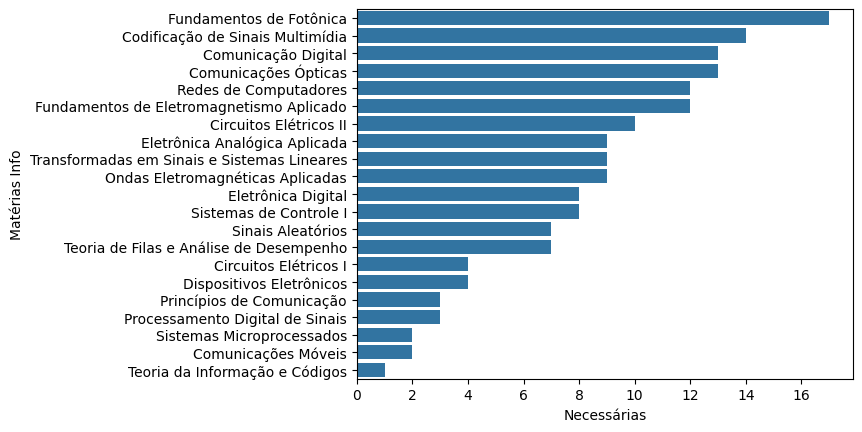

In [51]:
grafico = sns.barplot(y="materia", x="qtd_necessaria", data = df_materias_faltam2, order=df_materias_faltam2.sort_values('qtd_necessaria',ascending = False).materia)
grafico.set(xlabel='Necessárias', ylabel='Matérias Info')
grafico

***Análise do modelo***

Importância de cada feature

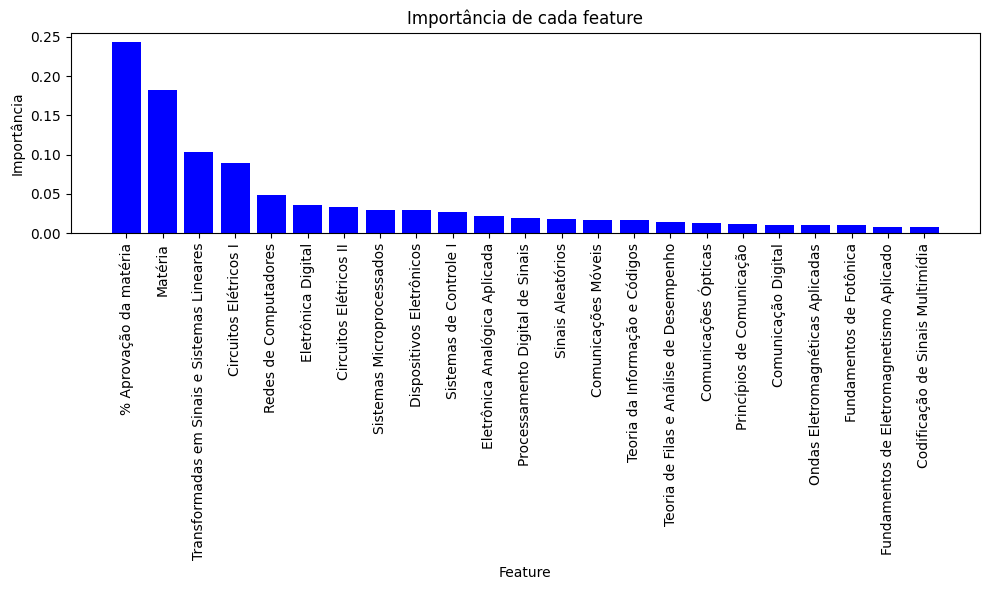

In [52]:


importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Dicionário de mapeamento das features
mapeamento_features = {
    0: 'Fundamentos de Fotônica',
    1: 'Circuitos Elétricos I',
    2: 'Fundamentos de Eletromagnetismo Aplicado',
    3: 'Circuitos Elétricos II',
    4: 'Dispositivos Eletrônicos',
    5: 'Eletrônica Analógica Aplicada',
    6: 'Eletrônica Digital',
    7: 'Transformadas em Sinais e Sistemas Lineares',
    8: 'Princípios de Comunicação',
    9: 'Sistemas de Controle I',
    10: 'Redes de Computadores',
    11: 'Sinais Aleatórios',
    12: 'Processamento Digital de Sinais',
    13: 'Comunicação Digital',
    14: 'Teoria da Informação e Códigos',
    15: 'Ondas Eletromagnéticas Aplicadas',
    16: 'Comunicações Ópticas',
    17: 'Codificação de Sinais Multimídia',
    18: 'Sistemas Microprocessados',
    19: 'Comunicações Móveis',
    20: 'Teoria de Filas e Análise de Desempenho',
    21: '% Aprovação da matéria',
    22: 'Matéria'
}

nomes_caracteristicas = [mapeamento_features[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.title("Importância de cada feature")
plt.bar(range(len(nomes_caracteristicas)), importances[indices], color="b", align="center")
plt.xticks(range(len(nomes_caracteristicas)), nomes_caracteristicas, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importância")
plt.tight_layout() 
plt.show()
